In [2]:
import math
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import statsmodels.api as sm

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import pymc3 as pm
# from pymc3.ode import DifferentialEquation
import arviz as az
import theano

plt.style.use('seaborn-darkgrid')

# plt.style.use('ggplot')
font_size = 14
plt.rcParams.update({'font.size': font_size})

/home/asa/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [199]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
df_usa_rates = pd.read_csv('../data/us_states_covid19_daily.csv')
df_usa_rates.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200510,AK,379.0,26985.0,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,27364,27364,27364,2,0.0,0.0,914.0,1.0,915.0
1,20200510,AL,9777.0,117644.0,NaN,NaN,1240.0,NaN,460.0,NaN,...,1240.0,127421,127421,127421,1,5.0,12.0,1717.0,210.0,1927.0
2,20200510,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,471.0,65528,65528,65528,5,0.0,0.0,0.0,0.0,0.0
3,20200510,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83,83,83,60,0.0,0.0,0.0,0.0,0.0
4,20200510,AZ,11119.0,126620.0,NaN,713.0,1528.0,300.0,NaN,195.0,...,1528.0,137739,137739,137739,4,4.0,14.0,8640.0,159.0,8799.0


In [4]:
df_usa_rates['datetime'] = pd.to_datetime(df_usa_rates['date'].astype(str), format='%Y%m%d')
df_usa_rates['d_o_y'] = pd.DatetimeIndex(df_usa_rates['datetime']).dayofyear
df_usa_rates.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y
0,20200510,AK,379.0,26985.0,NaN,8.0,NaN,NaN,NaN,NaN,...,27364,27364,2,0.0,0.0,914.0,1.0,915.0,2020-05-10,131
1,20200510,AL,9777.0,117644.0,NaN,NaN,1240.0,NaN,460.0,NaN,...,127421,127421,1,5.0,12.0,1717.0,210.0,1927.0,2020-05-10,131
2,20200510,AR,3747.0,61781.0,NaN,64.0,471.0,NaN,NaN,14.0,...,65528,65528,5,0.0,0.0,0.0,0.0,0.0,2020-05-10,131
3,20200510,AS,0.0,83.0,NaN,NaN,NaN,NaN,NaN,NaN,...,83,83,60,0.0,0.0,0.0,0.0,0.0,2020-05-10,131
4,20200510,AZ,11119.0,126620.0,NaN,713.0,1528.0,300.0,NaN,195.0,...,137739,137739,4,4.0,14.0,8640.0,159.0,8799.0,2020-05-10,131


In [9]:
states = ['NY']
df2 = df_usa_rates[df_usa_rates['state']==states[0]]
df2.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y
37,20200510,NY,335395.0,847603.0,NaN,7262.0,72715.0,2488.0,NaN,2073.0,...,1182998,1182998,36,207.0,460.0,26957.0,2273.0,29230.0,2020-05-10,131
93,20200509,NY,333122.0,820646.0,NaN,7776.0,72255.0,2664.0,NaN,2203.0,...,1153768,1153768,36,226.0,576.0,29510.0,2715.0,32225.0,2020-05-09,130
149,20200508,NY,330407.0,791136.0,NaN,8196.0,71679.0,2811.0,NaN,2295.0,...,1121543,1121543,36,217.0,527.0,28869.0,2758.0,31627.0,2020-05-08,129
205,20200507,NY,327649.0,762267.0,NaN,8665.0,71152.0,2976.0,NaN,2425.0,...,1089916,1089916,36,951.0,613.0,30324.0,3671.0,33995.0,2020-05-07,128
261,20200506,NY,323978.0,731943.0,NaN,9179.0,70539.0,NaN,NaN,NaN,...,1055921,1055921,36,232.0,672.0,24236.0,2786.0,27022.0,2020-05-06,127


In [10]:
num_days_smooth = 7
df2[f'Rolling-{num_days_smooth}mean'] = df2['positiveIncrease'].rolling(window=num_days_smooth, 
                                                                        center = True).mean()
df2.head()

/home/asa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,datetime,d_o_y,Rolling-7mean
37,20200510,NY,335395.0,847603.0,NaN,7262.0,72715.0,2488.0,NaN,2073.0,...,1182998,36,207.0,460.0,26957.0,2273.0,29230.0,2020-05-10,131,NaN
93,20200509,NY,333122.0,820646.0,NaN,7776.0,72255.0,2664.0,NaN,2203.0,...,1153768,36,226.0,576.0,29510.0,2715.0,32225.0,2020-05-09,130,NaN
149,20200508,NY,330407.0,791136.0,NaN,8196.0,71679.0,2811.0,NaN,2295.0,...,1121543,36,217.0,527.0,28869.0,2758.0,31627.0,2020-05-08,129,NaN
205,20200507,NY,327649.0,762267.0,NaN,8665.0,71152.0,2976.0,NaN,2425.0,...,1089916,36,951.0,613.0,30324.0,3671.0,33995.0,2020-05-07,128,2711.428571
261,20200506,NY,323978.0,731943.0,NaN,9179.0,70539.0,NaN,NaN,NaN,...,1055921,36,232.0,672.0,24236.0,2786.0,27022.0,2020-05-06,127,2877.857143


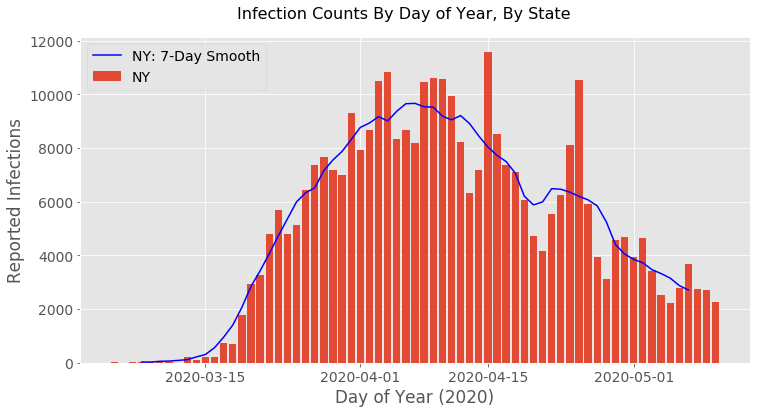

In [11]:
fig, ax = plt.subplots(figsize = (12,6))

ax.bar(df2.datetime, df2['positiveIncrease'], label = f"{states[0]}")
plt.plot(df2.datetime, df2[f'Rolling-{num_days_smooth}mean'], 
         label = f"{states[0]}: {num_days_smooth}-Day Smooth", color='blue')
ax.legend(loc='upper left')
ax.set_xlabel('Day of Year (2020)') 
ax.set_ylabel('Reported Infections') 
ax.label_outer()
plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();

## Add in CDC Reopen Threshold and replot

In [13]:
df_usa_pop = pd.read_csv('../data/us_state_population_2019.csv')
states_pop = [df_usa_pop.loc[df_usa_pop['ABBR'] == states[i],['POPEST18PLUS2019']].iloc[0,0] for i in range(len(states))]

# CDC guideline threshold of 10 reported infections per 100k pop every 14 days
reopen_thresh = 10./100000/14
state_reopen_thresh = [math.ceil(x * reopen_thresh) for x in states_pop]
state_reopen_thresh

[111]

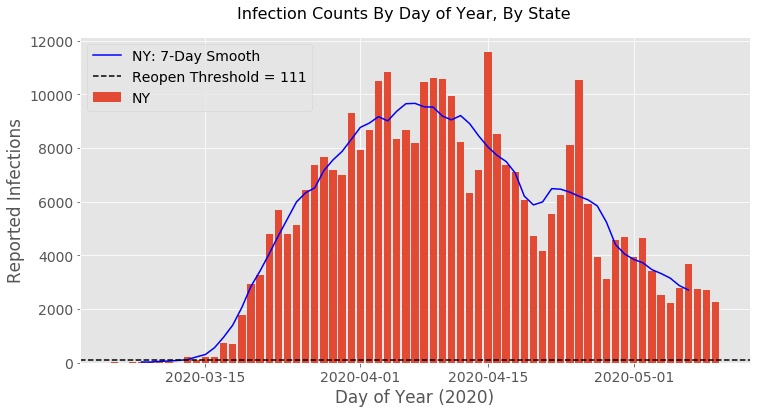

In [14]:
fig, ax = plt.subplots(figsize = (12,6))

ax.bar(df2.datetime, df2['positiveIncrease'], label = f"{states[0]}")
plt.plot(df2.datetime, df2[f'Rolling-{num_days_smooth}mean'], 
         label = f"{states[0]}: {num_days_smooth}-Day Smooth", color='blue')
ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", 
           label = f"Reopen Threshold = {state_reopen_thresh[0]}")
ax.legend(loc='upper left')
ax.set_xlabel('Day of Year (2020)') 
ax.set_ylabel('Reported Infections') 
ax.label_outer()
plt.suptitle('Infection Counts By Day of Year, By State', fontsize=16, y = 0.95)
plt.show();



## SEIR Modeling

In [17]:
def deriv_seir(y, t, N, beta, gamma, delta):
    S, E, I, R = y

    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    
    return dSdt, dEdt, dIdt, dRdt

In [219]:
N = states_pop[0]

N=70000
beta = .65 # infected person infects (beta) other persons per day
D = 3.2 # infections last (D) days
gamma = 1.0 / D
delta = 1.0 / .3 # incubation period of (1/delta) days

E0 = 10
S0, I0, R0 = N-E0, 0, 0
print(S0, E0, I0, R0)
print(f'beta =\t{beta:.3f}\ndelta =\t{delta:.3f}\ngamma =\t{gamma:.3f}\nR_0 =\t{beta/gamma:.3f}')

69990 10 0 0
beta =	0.650
delta =	3.333
gamma =	0.312
R_0 =	2.080


In [220]:
start_doy = 60
end_doy = 130
n_doy = end_doy - start_doy + 1
t = np.linspace(start_doy,end_doy,n_doy)
t_datetime = [pd.to_datetime(2020 * 1000 + t1[i], format='%Y%j') for i in range(len(t1))]
# Initial conditions vector
y0 = S0, E0, I0, R0
print(y0)
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

(69990, 10, 0, 0)


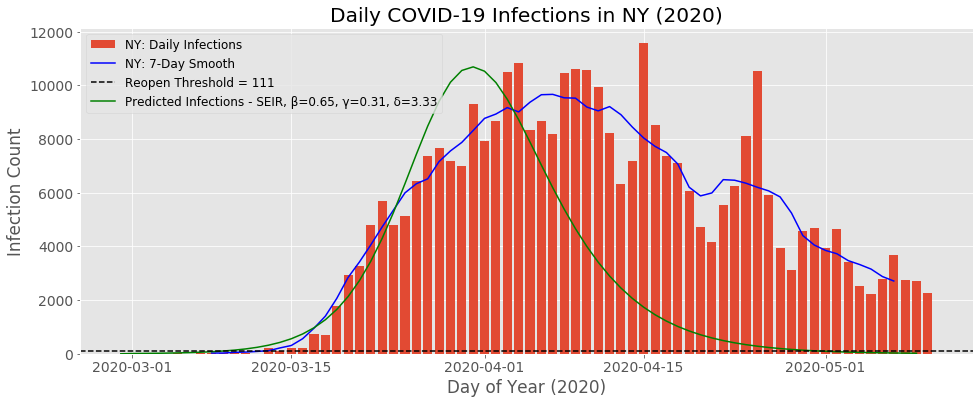

In [221]:
fig, ax = plt.subplots(figsize = (16,6))

plt.bar(df2.datetime, df2['positiveIncrease'], label = f"{states[0]}: Daily Infections")
plt.plot(df2.datetime, df2[f'Rolling-{num_days_smooth}mean'], 
         label = f"{states[0]}: {num_days_smooth}-Day Smooth", color='blue')
plt.plot(t_datetime, I, label = f'Predicted Infections - SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}',
         color = 'green')
ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", 
           label = f"Reopen Threshold = {state_reopen_thresh[0]}")

# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# # For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.tick_params(direction='out', length=10)
ax.set_xlabel('Day of Year (2020)')
ax.set_ylabel('Infection Count')
# ax.set_yscale('log')
plt.title(f'Daily COVID-19 Infections in {state} (2020)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
plt.show();
# fig.savefig('../images/seir_fit_to_NY_infections-01.png', dpi=250)

In [149]:
df2.datetime[37]+ pd.Timedelta(days=t)

TypeError: Invalid type <class 'numpy.ndarray'>. Must be int or float.

In [163]:
type(t[0])

numpy.float64

In [171]:
df2.d_o_y

37      131
93      130
149     129
205     128
261     127
       ... 
3523     68
3573     67
3613     66
3640     65
3658     64
Name: d_o_y, Length: 68, dtype: int64

In [179]:
t1 = np.int64(t)
print(t1[70])
# t_datetime = [pd.to_datetime(2020 * 1000 + t1[i], format='%Y%j') for i in t1]
t_datetime = [pd.to_datetime(2020 * 1000 + t1[i], format='%Y%j') for i in range(len(t1))]
print(t_datetime)

130
[Timestamp('2020-02-29 00:00:00'), Timestamp('2020-03-01 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-03 00:00:00'), Timestamp('2020-03-04 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00'), Timestamp('2020-03-07 00:00:00'), Timestamp('2020-03-08 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-14 00:00:00'), Timestamp('2020-03-15 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-21 00:00:00'), Timestamp('2020-03-22 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'), Timestamp('2020-03-28 00:00:00'), Timestamp

## MCMC examples and testing

In [182]:
N = 1000
beta = 1.0 # infected person infects 1 other person per day
D = 4.0 # infections last 4 days
gamma = 1.0 / D
delta = 1.0 / 3 # incubation period of 3 days

S0, E0, I0, R0 = N-1, 1, 0, 0

In [183]:
t = np.linspace(50,150,100)
# Initial conditions vector
y0 = S0, E0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

In [184]:
def plotseir(t, S, E, I, R, R0=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Population Count')
    plt.title(f'SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();
    f.savefig(f"../images/generic_seir_trends.png", dpi=250)

    if R0 is not None:
        f = plt.figure(figsize=(12,4))
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

    plt.show();

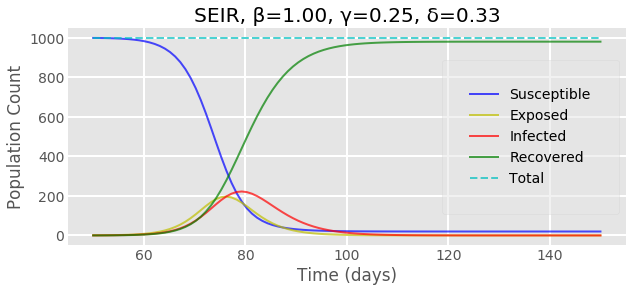

In [185]:
plotseir(t, S, E, I, R)

In [187]:
df_county = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
df_county.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [189]:
len(np.unique(df_county['fips']))

5071

In [190]:
df_county['state-county'] = df_county['state'] + "-" + df_county['county']
df_county.head()

,date,county,state,fips,cases,deaths,state-county
0,2020-01-21,Snohomish,Washington,53061.0,1,0,Washington-Snohomish
1,2020-01-22,Snohomish,Washington,53061.0,1,0,Washington-Snohomish
2,2020-01-23,Snohomish,Washington,53061.0,1,0,Washington-Snohomish
3,2020-01-24,Cook,Illinois,17031.0,1,0,Illinois-Cook
4,2020-01-24,Snohomish,Washington,53061.0,1,0,Washington-Snohomish


In [195]:
state_county_count = len(np.unique(df_county['state-county']))
county_count = len(np.unique(df_county['county']))
print(f'There are {state_county_count} unique state-county pairs, but only {county_count} unique county names.')

There are 3012 unique state-county pairs, but only 1760 unique county names.


In [197]:
df_county_pop = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv', encoding='latin-1')
df_county_pop.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [215]:
county_pop = df_county_pop.loc[(df_county_pop['STNAME']=='New York') & (df_county_pop['CTYNAME']=='New York County'), 'POPESTIMATE2019'].values[0]
print(f'County pop is {county_pop}, type is {type(county_pop)}')

County pop is 1628706, type is <class 'numpy.int64'>


## Functions and Classes

In [27]:
def get_state_or_county_data(region, num_days = 7):
    '''
    Extracts the daily and cumulative totals of infections and deaths for a given region,
        as well as population for that region.  
    
    INPUT:
        - region: A tuple for the region of interest, of the form ('State':'County').
            The County should not have the term 'County' in it.
            Data for the entire state can be extracted by listing the 'NA' for the county.
        - num_days: number of days to apply centered rolling average
    OUTPUT: 
        - df_cases_deaths: A Pandas dataframe with time series of infections 
            and deaths (total and daily) for the specified region
        - region_pop: (Int64) Population (2019 estimate) for the specified region 
    '''
    if region[1]=='NA':
        print('state only')
        df_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
        df_cases_region = df_cases.loc[(df_cases['state']==region[0])].reset_index()
        county_popul = region[0]
    else:
        print('state and county')
        df_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
        df_cases_region = df_cases.loc[(df_cases['state']==region[0]) & (df_cases['county'].str.startswith(region[1]))].reset_index()
        county_popul = region[1] + ' County'
        
    df_cases_region['daily_cases'] = df_cases_region['cases'] - df_cases_region['cases'].shift(1)
    df_cases_region['daily_cases'].fillna(value=0, inplace=True)
    df_cases_region['daily_deaths'] = df_cases_region['deaths'] - df_cases_region['deaths'].shift(1)
    df_cases_region['daily_deaths'].fillna(value=0, inplace=True)
    df_cases_region[f'daily_cases_roll{num_days}mean'] = df_cases_region['daily_cases'].rolling(window=num_days, center = True).mean()
    
    cols_to_move = ['cases', 'daily_deaths','deaths']
    df_cases_region = df_cases_region[[ col for col in df_cases_region.columns if col not in cols_to_move] + cols_to_move]
    
    df_pop = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv', encoding='latin-1')
    region_pop = df_pop.loc[(df_pop['STNAME']==region[0]) & (df_pop['CTYNAME']==county_popul), 'POPESTIMATE2019'].values[0]
    
    return df_cases_region, region_pop

In [29]:
def plot_cases(df_cases_region, I, num_days=7):
    fig, ax = plt.subplots(figsize = (16,6))

    plt.bar(df_cases_region.date, df_cases_region['daily_cases'], label = f"{states[0]}: Daily Infections")
    plt.plot(df_cases_region.date, df2[f'Rolling-{num_days}mean'], 
             label = f"{df_cases_region.state[0]}: {num_days}-Day Smooth", color='blue')
    plt.plot(t_datetime, I, label = f'Predicted Infections - SEIR, β={beta:.2f}, γ={gamma:.2f}, δ={delta:.2f}',
             color = 'green')
    ax.axhline(state_reopen_thresh[0], color = 'black', ls="--", 
               label = f"Reopen Threshold = {state_reopen_thresh[0]}")

    # ax.xaxis.set_major_locator(MultipleLocator(5))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # # For the minor ticks, use no labels; default NullFormatter.
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    # ax.tick_params(direction='out', length=10)
    ax.set_xlabel('Day of Year (2020)')
    ax.set_ylabel('Infection Count')
    # ax.set_yscale('log')
    plt.title(f'Daily COVID-19 Infections in {state} (2020)')
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [3,0,2,1]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12,loc='upper left')
    plt.show();

In [28]:
region = ('Colorado','Boulder')
region = ('New York','New York')
print(region[1])
num_days_smooth = 7

df_cases_region, region_pop = get_state_or_county_data(region, num_days=num_days_smooth)

print(f'Population of {region[1]}, {region[0]} is {region_pop}.')
df_cases_region.head(10)

New York
state and county
Population of New York, New York is 1628706.


,index,date,county,state,fips,daily_cases,daily_cases_roll7mean,cases,daily_deaths,deaths
0,416,2020-03-01,New York City,New York,NaN,0.0,NaN,1,0.0,0
1,448,2020-03-02,New York City,New York,NaN,0.0,NaN,1,0.0,0
2,482,2020-03-03,New York City,New York,NaN,1.0,NaN,2,0.0,0
3,518,2020-03-04,New York City,New York,NaN,0.0,1.571429,2,0.0,0
4,565,2020-03-05,New York City,New York,NaN,2.0,1.857143,4,0.0,0
5,627,2020-03-06,New York City,New York,NaN,1.0,2.714286,5,0.0,0
6,715,2020-03-07,New York City,New York,NaN,7.0,5.000000,12,0.0,0
7,820,2020-03-08,New York City,New York,NaN,2.0,7.142857,14,0.0,0
8,947,2020-03-09,New York City,New York,NaN,6.0,13.142857,20,0.0,0
9,1098,2020-03-10,New York City,New York,NaN,17.0,21.428571,37,0.0,0


In [247]:
df_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
df_cases_region = df_cases.loc[(df_cases['state']==region[0])].reset_index()
df_cases_region.head()

,index,date,state,fips,cases,deaths
0,246,2020-03-01,New York,36,1,0
1,261,2020-03-02,New York,36,1,0
2,276,2020-03-03,New York,36,2,0
3,293,2020-03-04,New York,36,11,0
4,313,2020-03-05,New York,36,22,0


In [250]:
range(df_cases_region.shape[0])

range(0, 92)

In [251]:
(df_cases_region['cases'][4] - df_cases_region['cases'][3])

11

In [260]:
df_cases_region['daily_cases'] = df_cases_region['cases'] - df_cases_region['cases'].shift(1)
df_cases_region['daily_cases'].fillna(value=0, inplace=True)
df_cases_region['daily_deaths'] = df_cases_region['deaths'] - df_cases_region['deaths'].shift(1)
df_cases_region['daily_deaths'].fillna(value=0, inplace=True)
df_cases_region.head(10)

,index,date,state,fips,cases,deaths,daily_cases,daily_deaths
0,246,2020-03-01,New York,36,1,0,0.0,0.0
1,261,2020-03-02,New York,36,1,0,0.0,0.0
2,276,2020-03-03,New York,36,2,0,1.0,0.0
3,293,2020-03-04,New York,36,11,0,9.0,0.0
4,313,2020-03-05,New York,36,22,0,11.0,0.0
5,338,2020-03-06,New York,36,44,0,22.0,0.0
6,369,2020-03-07,New York,36,89,0,45.0,0.0
7,404,2020-03-08,New York,36,106,0,17.0,0.0
8,440,2020-03-09,New York,36,142,0,36.0,0.0
9,478,2020-03-10,New York,36,173,0,31.0,0.0


In [235]:
df_cases = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
df_cases.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


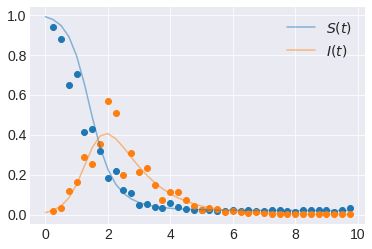

In [21]:
# https://docs.pymc.io/notebooks/ODE_API_introduction.html
def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    return [ds, di]

times = np.arange(0,10,0.25)

beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta,gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])


plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [7]:
yobs

array([[1.14430156, 0.01554874],
       [0.90786389, 0.02490101],
       [0.52230932, 0.058287  ],
       [0.6467751 , 0.19594394],
       [0.52040536, 0.1600454 ],
       [0.49248278, 0.51470352],
       [0.51776738, 0.37028686],
       [0.2121676 , 0.46643972],
       [0.13911128, 0.49966061],
       [0.07132027, 0.24007685],
       [0.099401  , 0.24083479],
       [0.0521753 , 0.11748284],
       [0.05095781, 0.16534228],
       [0.04216825, 0.18080835],
       [0.03457119, 0.17326038],
       [0.03140741, 0.10042769],
       [0.03455665, 0.06592352],
       [0.03258024, 0.04842862],
       [0.02142044, 0.06042324]])

In [23]:
# https://docs.pymc.io/notebooks/getting_started.html
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [304]:
## SI model
 
from pymc3 import *
from numpy import *
 
#observed data
T = 10
susceptible_data = array([999,997,996,994,993,992,990,989,986,984])
infected_data = array([1,2,5,6,7,8,9,11,13,15])
 
# stochastic priors
beta = Uniform('beta', 0., 40., value=1.)
gamma = Uniform('gamma', 0., 1., value=.001)
SI_0 = Uninformative('SI_0', value=[999., 1.])
 
# deterministic compartmental model
@deterministic
def SI(SI_0=SI_0, beta=beta, gamma=gamma):
    S = zeros(T)
    I = zeros(T)
    S[0] = SI_0[0]
    I[0] = SI_0[1]
    for i in range(1,T):
        S[i] = S[i-1] - 0.05*beta*S[i-1]*I[i-1]/(S[i-1]+I[i-1])
        I[i] = max(0., I[i-1] + 0.05*beta*S[i-1]*I[i-1]/(S[i-1]+I[i-1]) - gamma*I[i-1])
    return S, I
S = Lambda('S', lambda SI=SI: SI[0])
I = Lambda('I', lambda SI=SI: SI[1])
 
# data likelihood
A = Poisson('A', mu=S, value=susceptible_data, observed=True)
B = Poisson('B', mu=I, value=infected_data, observed=True)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.